In [ ]:
import argparse

## Initializare hyperparametri model la nivel de args, suporta cmdline-execution

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=2, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=1024, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=400, help="interval between image sampling")
opt = parser.parse_args(args=[])
print(opt)


Namespace(n_epochs=2, batch_size=1024, lr=0.0002, b1=0.5, b2=0.999, n_cpu=8, latent_dim=100, img_size=32, channels=1, sample_interval=400)


In [ ]:
import numpy as np
import math
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
cuda = True if torch.cuda.is_available() else False

In [ ]:
# m - stratul retelei
def weights_init_normal(m):
    classname = m.__class__.__name__ # Obtin numele stratului
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02) # Initializare dupa distributie normala gausiana de medie 0 si std 0.02
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02) # Initializare dupa distributie normala gausiana de medie 0 si std 0.02
        torch.nn.init.constant_(m.bias.data, 0.0) # Bias initial 0

# BatchNorm2D normalizează fiecare canal pe baza mediei și deviației standard a valorilor sale în batch-ul curent

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt.img_size // 4 # Declaram dimensiunea inaginii initiale
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2)) # input -> vectorul de zgomot, out -> features(128) * dim imaginii


        ## Reconstructia imaginii
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),

            nn.Upsample(scale_factor=2), # \\4 -> \\2
            nn.Conv2d(128, 128, 3, stride=1, padding=1), # Conv pe uppersampling
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2), # \\2 -> \\1
            nn.Conv2d(128, 64, 3, stride=1, padding=1), # Conv pe uppersampling
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1), # Convertim la imaginea de input (color sau gray). Nu mai fac conv transpose pentru ca sunt deja la dimensiunea imaginii
            nn.Tanh(), # Normalizarea iesirii
        )

    def forward(self, z):
        out = self.l1(z) # Transforma zgomotul intr-o reprezentare intermediara
        out = out.view(out.shape[0], 128, self.init_size, self.init_size) # Reshape pentru input la blocurile convolutionale
        img = self.conv_blocks(out) # obtine imaginea rezultat (batch_size, channels, img_size, img_size)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        ds_size = opt.img_size // 2 ** 4 # Dimensiunea imaginii dupa 4 pasi de downsampling
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1),
                                       nn.Sigmoid()) # Obtine predictia finala

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

## 3x3 e pentru mai multe detalii fine, imaginea este 32x32 este ok si cu acesta
## 4x4 pentru mai multe caracteristici, folositi pentru imagini de dimensiune mai mare

In [ ]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)


Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (adv_laye

In [ ]:
# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]


Extracting ../../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 562kB/s]


Extracting ../../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 5.16MB/s]


Extracting ../../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.92MB/s]

Extracting ../../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw



In [ ]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
from torch.autograd import Variable
# ----------
#  Training
# ----------
for epoch in range(opt.n_epochs): # Itereaza prin fiecare epoca
    for i, (imgs, _) in enumerate(dataloader): # Scot imaginile din fiecare batch

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False) # Tensor eticheta pentru valori reale
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False) # Tensor eticheta pentru valori false

        # Configure input
        real_imgs = Variable(imgs.type(Tensor)) # Conversie la tensori

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad() # Reseteaza gradientul pentru generator


        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim)))) # Se creeaza vectorul de zgomot

        # Generam un batch de imagini
        gen_imgs = generator(z) # Se trece zgomotul prin generator pentru a genera imagini false

        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step() # Propagare backwards and update

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad() # Reseteaza gradientul pentru discriminator
        real_loss = adversarial_loss(discriminator(real_imgs), valid) # Se trec imaginile prin discriminator si se calculeaza pierderile pe imaginile reale
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake) # Se iau imaginile false gen_imgs se trec prin discriminator si se calculeaza pierderile

        d_loss = (real_loss + fake_loss) / 2 # Calcul pierdere discriminator

        d_loss.backward()
        optimizer_D.step() # Actualizare si backward prop

        # Print detalii antrenare
        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i

In [ ]:
generator.eval()

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

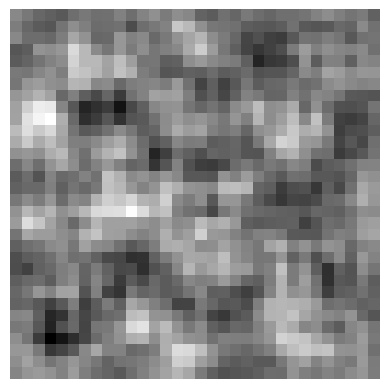

In [ ]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)

latent_dim = 100
z = torch.randn(1, latent_dim).to(device)
with torch.no_grad():
    fake_img = generator(z)

fake_img = (fake_img + 1) / 2


# Display
img = fake_img.squeeze().cpu().numpy()  # Convert to NumPy and move to CPU
plt.imshow(img, cmap="gray")  # Show grayscale image
plt.axis("off")
plt.show()

In [ ]:
with torch.no_grad():
    prediction = discriminator(fake_img)

# Print discriminator's output
print(f"Discriminator's Output: {prediction.item():.4f}")

Discriminator's Output: 0.4907
